In [8]:
import os
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style='ticks')

In [9]:
%matplotlib notebook

In [37]:
working_dir = '/mnt/cephfs/organoid/datasets/organoid_phenotyping/analysis/Arlotta_d34_vs_Arlotta_d56'
os.listdir(working_dir)

['cyto_profiles_combined_samples.npy',
 'arlotta_d34_and_arlotta_d35_combined_features.xlsx',
 'Arlotta_d34',
 'Arlotta_d56',
 'combined_features.xlsx',
 'analysis.csv',
 'model_d34_and_d56.umap',
 'cyto_labels_combined.npy',
 'cyto_profiles_combined.npy']

In [11]:
analysis_dataset = pd.read_csv("/mnt/cephfs/organoid/datasets/organoid_phenotyping/analysis/Arlotta_d34_vs_Arlotta_d56/analysis.csv")
print(analysis_dataset)

                                                 path         type
0   20190722_16_28_25_ef26_org1_488LP15_561LP140_6...  Arlotta_d56
1   20190722_17_48_57_ef26_org2_488LP14_561LP140_6...  Arlotta_d56
2   20190722_18_32_43_ef26_org3_488LP14_561LP140_6...  Arlotta_d56
3   20190722_19_18_01_ef26_org4_488LP14_561LP140_6...  Arlotta_d56
4   20190723_11_41_12_ef26_org5_488LP14_561LP140_6...  Arlotta_d56
5   20190723_12_09_45_ef26_org6_488LP14_561LP140_6...  Arlotta_d56
6   20191117_14_13_22_AA_ArlottaOrg1_488LP14_561LP...  Arlotta_d34
7   20191117_14_32_32_AA_ArlottaOrg2_488LP16_561LP...  Arlotta_d34
8   20191117_14_42_04_AA_ArlottaOrg3_488LP17_561LP...  Arlotta_d34
9   20191117_14_53_16_AA_ArlottaOrg4_488LP16_561LP...  Arlotta_d34
10  20191117_15_07_58_AA_ArlottaOrg5_488LP14_561LP...  Arlotta_d34


In [12]:
profiles = np.load(os.path.join(working_dir, 'cyto_profiles_combined.npy'))
profiles.shape

(55000, 3, 6)

In [13]:
features = profiles.reshape((len(profiles), -1))

Optional scaling and preprocessing

In [7]:
means = profiles.mean(axis=0).mean(axis=-1) * np.ones((5, 3))
scaled_profiles = profiles / means.T

ValueError: operands could not be broadcast together with shapes (55000,3,6) (3,5) 

In [14]:
from sklearn.preprocessing import scale

In [15]:
scaled_features = scale(features)

Flattened profiles seem best here...

In [16]:
np.random.seed(7)
model = UMAP(metric='euclidean').fit(features)
x_umap = model.transform(features)
x_umap.shape

(55000, 2)

<IPython.core.display.Javascript object>


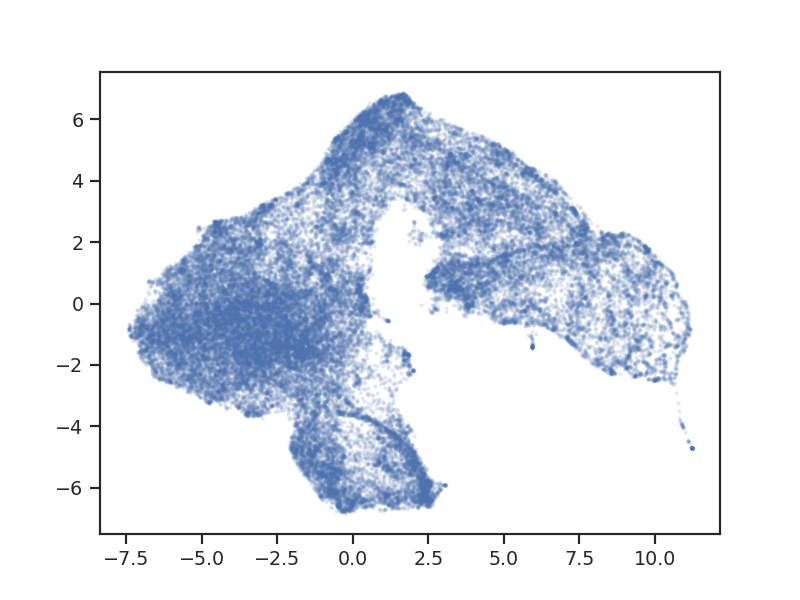

In [17]:
plt.plot(x_umap[:, 0], x_umap[:, 1], '.', alpha=0.1, markersize=3)
plt.show()

Filter bad profiles

In [18]:
good_idx = np.where(x_umap[:, 0] > -8)
x_umap = x_umap[good_idx]
features = features[good_idx]

In [19]:
profiles = profiles[good_idx]

<IPython.core.display.Javascript object>


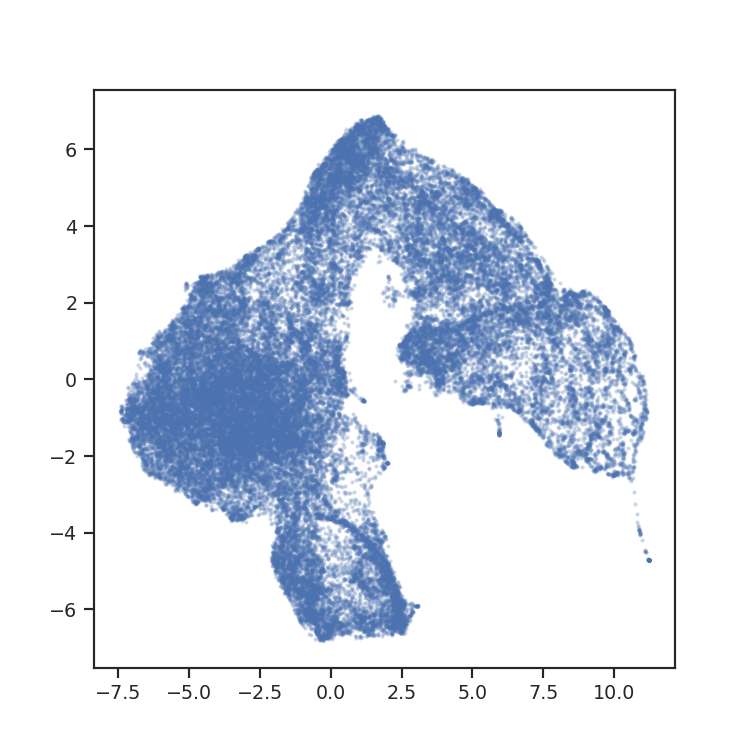

In [20]:
plt.figure(figsize=(6, 6))
plt.plot(x_umap[:, 0], x_umap[:, 1], '.', alpha=0.2, markersize=3)
plt.show()

In [21]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.lines as mlines

Agglomerative Clustering

In [22]:
clustering = AgglomerativeClustering(n_clusters=8, linkage='average').fit(x_umap)
labels = clustering.labels_

class_labels = np.unique(labels)
class_labels

array([0, 1, 2, 3, 4, 5, 6, 7])

<IPython.core.display.Javascript object>


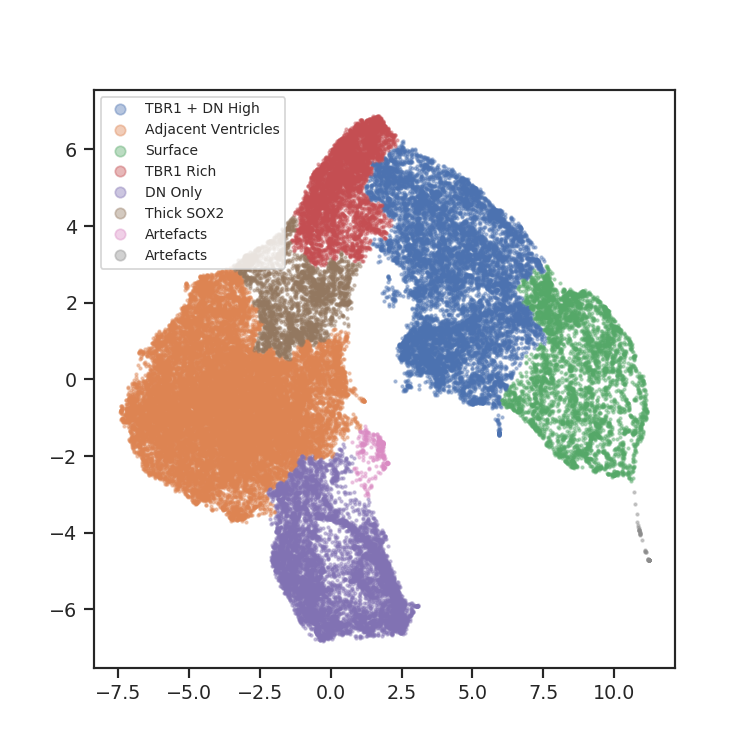

In [23]:
cluster_names = ['TBR1 + DN High',
                 'Adjacent Ventricles',
                 'Surface',
                 'TBR1 Rich',
                 'DN Only',
                 'Thick SOX2', 
                 'Artefacts',
                 'Artefacts']

plt.figure(figsize=(6, 6))
for i in range(0, class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(x_umap[idx, 0], x_umap[idx, 1], '.',alpha=0.4, markersize=3,label= cluster_names[i])
plt.legend(loc=2, markerscale=4.0, fontsize=8.0)
# plt.xlim([-8, 8])
plt.show()

Show organoid labels

In [24]:
sample_labels = np.load(os.path.join(working_dir, 'cyto_profiles_combined_samples.npy')).astype(np.int)
np.unique(sample_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [25]:
sample_labels = sample_labels[good_idx]

<IPython.core.display.Javascript object>


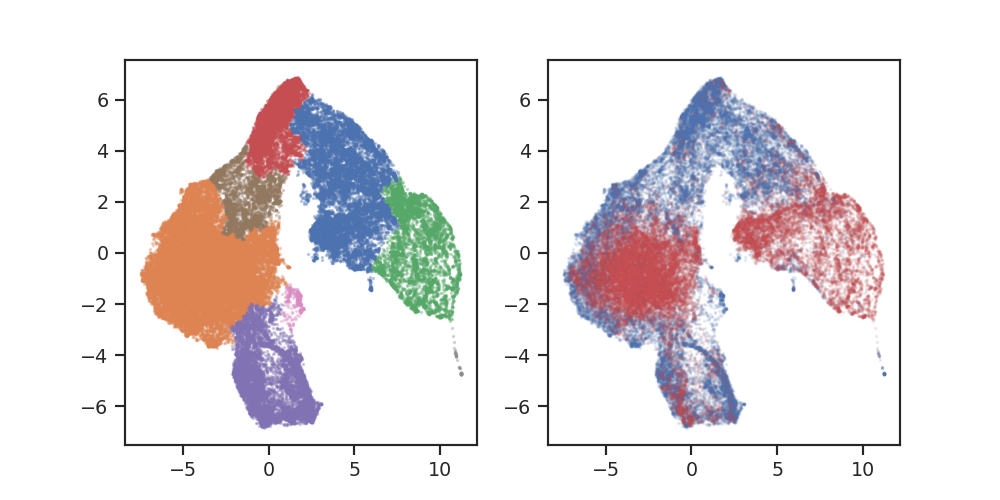

In [26]:
group1 = [0, 1, 2, 3, 4, 5] #d56
group2 = [6, 7, 8, 9, 10]   #d34

plt.figure(figsize=(8, 4))

plt.subplot(121)
for i in range(0, class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(x_umap[idx, 0], x_umap[idx, 1], '.', alpha=0.3, markersize=2, label=f'Cluster {i}')
# plt.legend()
    
plt.subplot(122)
for i in np.unique(sample_labels):
    idx = np.where(sample_labels == i)[0]
    if i in group2:
        plt.plot(x_umap[idx, 0], x_umap[idx, 1], 'r.', alpha=0.1, markersize=2)
    elif i in group1:
        plt.plot(x_umap[idx, 0], x_umap[idx, 1], 'b.', alpha=0.1, markersize=2)
plt.show()

Inpsect profiles interactively

In [27]:
from sklearn.neighbors import NearestNeighbors

In [28]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

<IPython.core.display.Javascript object>


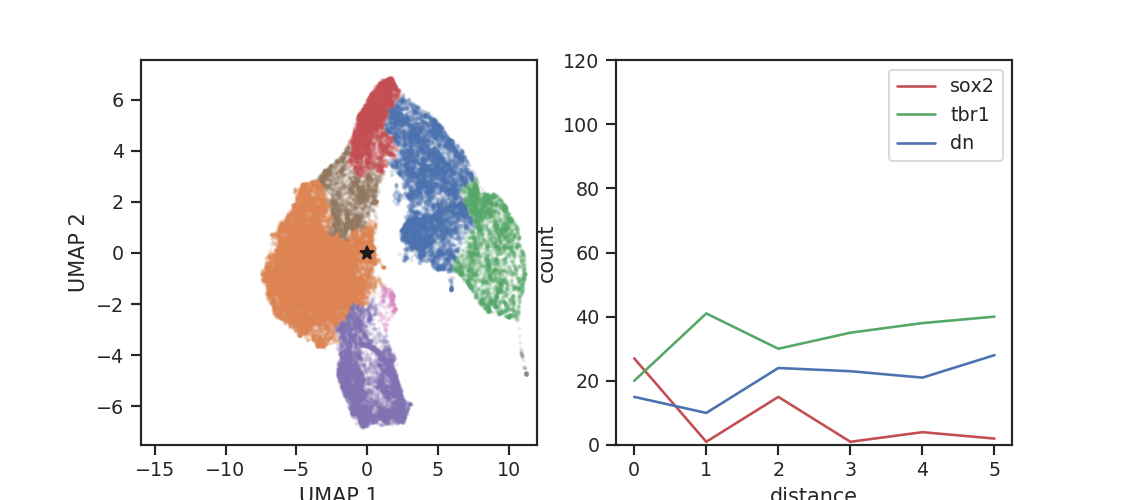

interactive(children=(FloatSlider(value=0.0, description='x', max=12.0, min=-16.0, step=0.05), FloatSlider(val…

In [29]:
%matplotlib notebook

x = -6
y = 4

min_val = -16
max_val = 12

embedding = x_umap

fig = plt.figure(figsize=(9, 4))

ax0 = plt.subplot(121)
for i in range(class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(embedding[idx, 0], embedding[idx, 1], '.', markersize=3, alpha=0.1)
line, = plt.plot(x, y, 'k*', markersize=8)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim([min_val, max_val])

ax1 = plt.subplot(122)
ax1.set_ylim([0, 120])

nbrs = NearestNeighbors(1).fit(embedding)
dist, idx = nbrs.kneighbors(np.asarray([[x, y]]))
profile = profiles[idx][0, 0]

names = ['sox2', 'tbr1', 'dn']
colors = ['r', 'g', 'b']
line_profiles = []
for i, p in enumerate(profile):
    line_profile, = plt.plot(p, label=names[i], color=colors[i])
    line_profiles.append(line_profile)
plt.xlabel('distance')
plt.ylabel('count')
plt.legend(loc=1)
    
def update(x=0.0, y=0.0):
    line.set_xdata([x])
    line.set_ydata([y])
    
    _, idx = nbrs.kneighbors(np.asarray([[x, y]]))
    profile = profiles[idx][0, 0]
    for line_profile, p in zip(line_profiles, profile):
        line_profile.set_ydata(p)
    ax1.autoscale_view(None, False, True)
    fig.canvas.draw_idle()
    
interact(update, 
         x=widgets.FloatSlider(min=min_val, max=max_val, step=0.05),
         y=widgets.FloatSlider(min=min_val, max=max_val, step=0.05))

plt.show()

Show sample of profiles from each cluster

<IPython.core.display.Javascript object>


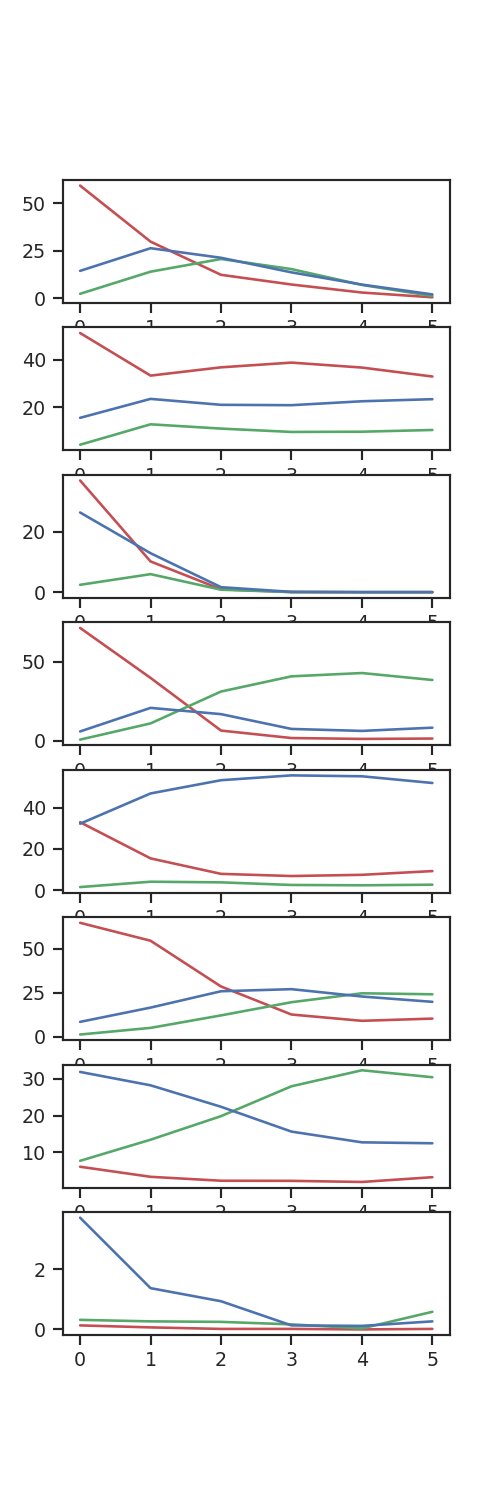

In [30]:
colors = ['r', 'g', 'b']
plt.figure(figsize=(4, 12))
for i in np.unique(class_labels):
    idx = np.where(labels == i)[0]
    profile_cluster = profiles[idx]
    average_profile = profile_cluster.mean(axis=0)
    
    plt.subplot(class_labels[-1] + 1, 1, i+1)
    for p, c in zip(average_profile, colors):
        plt.plot(p, color=c)
plt.show()

<IPython.core.display.Javascript object>


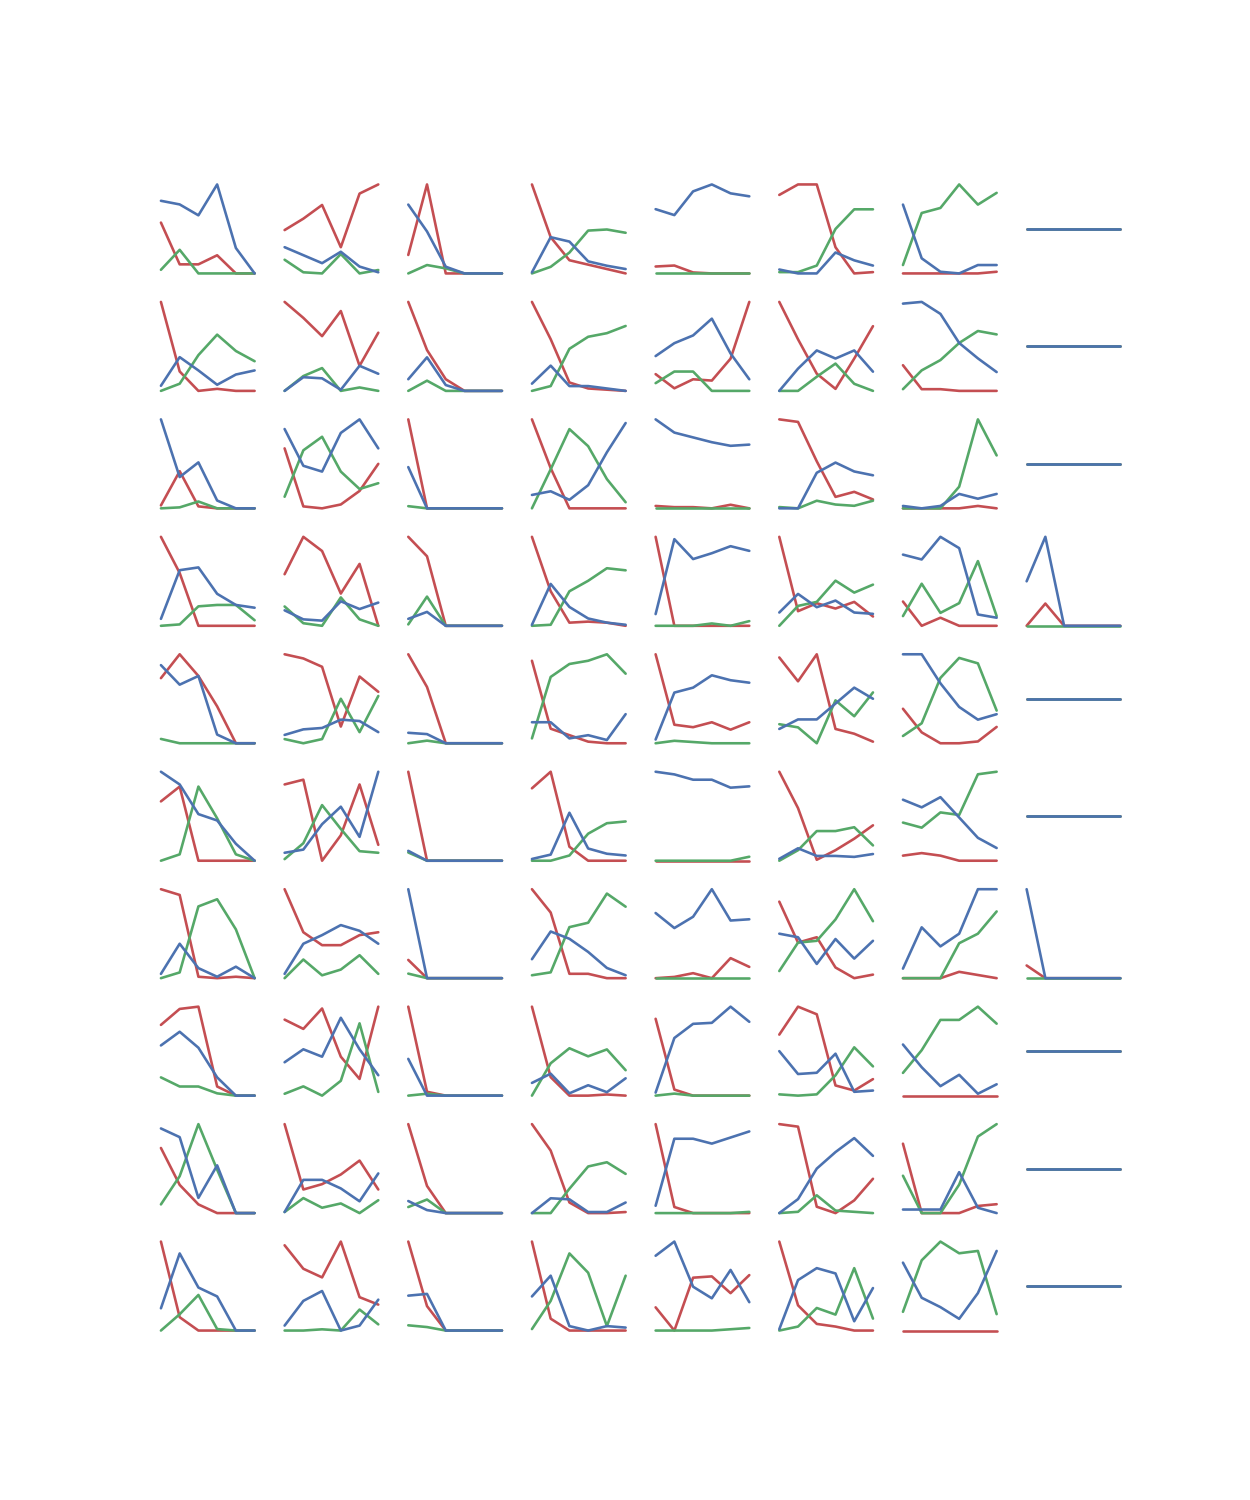

In [31]:
n_profiles = 10

plt.figure(figsize=(10, 12))
for i in np.unique(class_labels):
    idx = np.where(labels == i)[0]
    profile_cluster = profiles[idx]
    
    np.random.shuffle(profile_cluster)
    sample = profile_cluster[:n_profiles]
    
    for j, s in enumerate(sample):
        subplot_idx = len(class_labels) * j + i + 1
        plt.subplot(n_profiles, class_labels[-1] + 1, subplot_idx)
        for p, c in zip(s, colors):
            plt.plot(p, color=c)
            plt.axis('off')
plt.show()

- Euclidean distance metric, 6 clusters on UMAP looks good
- Correlation distance metric, 5 clusters may look better

Build Seaborn Lineplots

In [32]:
import pandas as pd
import seaborn as sns

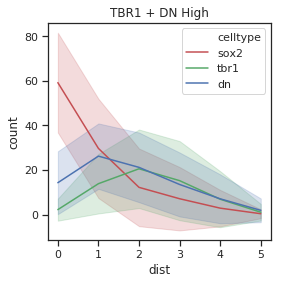

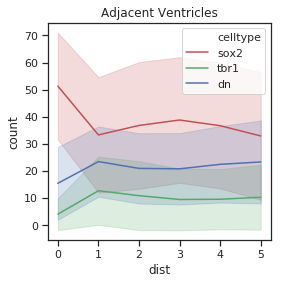

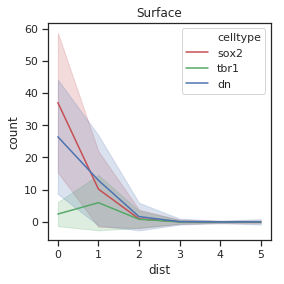

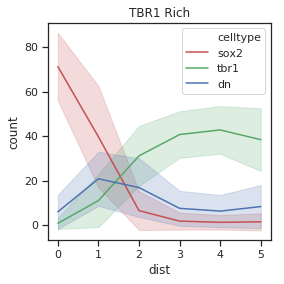

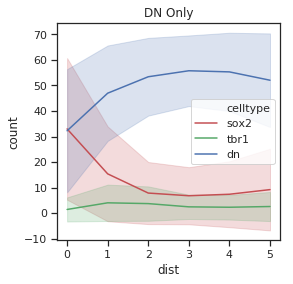

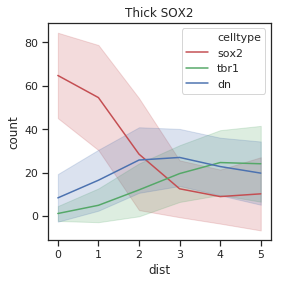

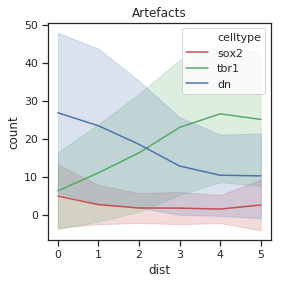

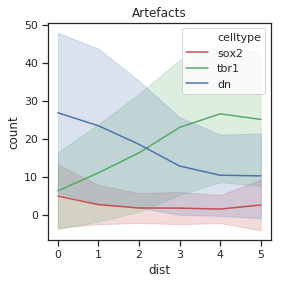

In [33]:
%matplotlib inline
cluster_names = ['TBR1 + DN High',
                 'Adjacent Ventricles',
                 'Surface',
                 'TBR1 Rich',
                 'DN Only',
                 'Thick SOX2', 
                 'Artefacts',
                 'Artefacts']

celltype_names = ['sox2', 'tbr1', 'dn']

for cluster_to_plot in range(len(cluster_names)):
    
    dist = []
    count = []
    celltype = []
    cluster = []
    
    for i, profile in enumerate(profiles):
        for k, p in enumerate(profile):
            for b, c in enumerate(p):
                cluster_name = cluster_names[labels[i]]
                if cluster_name == cluster_names[cluster_to_plot]:
                    dist.append(b)
                    count.append(c)
                    cluster.append(cluster_name)
                    celltype.append(celltype_names[k])
                    
    df = pd.DataFrame({'dist': dist, 
                       'count': count, 
                       'celltype': celltype})
    
    # Plot this cluster average profile
    plt.figure(figsize=(4, 4))
    sns.lineplot(x="dist", y="count",
             hue="celltype", ci='sd', palette=['r', 'g', 'b'],
             data=df)
    plt.title(cluster_names[cluster_to_plot])
    plt.show()

Save the cluster labels

In [34]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [35]:
np.save(os.path.join(working_dir, 'cyto_labels_combined.npy'), labels)

Save the UMAP embedding

In [36]:
import joblib

filename = 'model_d34_and_d56.umap'
joblib.dump(model, os.path.join(working_dir, filename))

['/mnt/cephfs/organoid/datasets/organoid_phenotyping/analysis/Arlotta_d34_vs_Arlotta_d56/model_d34_and_d56.umap']